RESEAU CNN+ELA 
detection de photomontage 

In [102]:
# Importation des bibliothèques nécessaires
import os
import numpy as np
import cv2
from PIL import Image, ImageChops, ImageEnhance
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# FONCTIONS

Error level analysis: 


In [103]:
# Fonction pour générer l'image ELA
def ela_image(path, quality=60):
    original = Image.open(path).convert('RGB')
    resaved = 'resaved.jpg'
    original.save(resaved, 'JPEG', quality=quality)
    resaved_image = Image.open(resaved)
    ela_image = ImageChops.difference(original, resaved_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image

In [104]:
# # Chargement des données et génération des images ELA
# def load_dataset(real_folder, fake_folder):
#     ela_images = []
#     labels = []

#     # Chargement des images réelles
#     for filename in os.listdir(real_folder):
#         file_path = os.path.join(real_folder, filename)
#         ela_img = ela_image(file_path)
#         ela_img = ela_img.resize((128, 128))
#         ela_img = np.array(ela_img)
#         ela_images.append(ela_img)
#         labels.append(0)  # Label pour les images réelles

#     # Chargement des images truquées
#     for filename in os.listdir(fake_folder):
#         file_path = os.path.join(fake_folder, filename)
#         ela_img = ela_image(file_path)
#         ela_img = ela_img.resize((128, 128))
#         ela_img = np.array(ela_img)
#         ela_images.append(ela_img)
#         labels.append(1)  # Label pour les images truquées

#     ela_images = np.array(ela_images)
#     labels = np.array(labels)
#     return ela_images, labels

In [105]:
# Chargement des données et génération des images ELA
def load_dataset(real_folder, fake_folder):
    ela_images = []
    labels = []

    # Chargement des images réelles
    for filename in os.listdir(real_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.jfif')):
            file_path = os.path.join(real_folder, filename)
            ela_img = ela_image(file_path)
            ela_img = ela_img.resize((128, 128))
            ela_img = np.array(ela_img)
            ela_images.append(ela_img)
            labels.append(0)  # Label pour les images réelles

    # Chargement des images truquées
    for filename in os.listdir(fake_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.jfif')):
            file_path = os.path.join(fake_folder, filename)
            ela_img = ela_image(file_path)
            ela_img = ela_img.resize((128, 128))
            ela_img = np.array(ela_img)
            ela_images.append(ela_img)
            labels.append(1)  # Label pour les images truquées

    ela_images = np.array(ela_images)
    labels = np.array(labels)
    return ela_images, labels

fonction permettant d'afficher des images reel et fake après le traitement ELA

In [106]:
def plot_ela_images(images, labels, num_real=3, num_fake=3):
    real_indices = [i for i, label in enumerate(labels) if label == 0][:num_real]
    fake_indices = [i for i, label in enumerate(labels) if label == 1][:num_fake]
    selected_indices = real_indices + fake_indices
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        ax = plt.subplot(2, max(num_real, num_fake), i + 1)
        plt.imshow(images[idx])
        plt.title("Real" if labels[idx] == 0 else "Fake")
        plt.axis("off")
    plt.show()

fonction affichant le nombres d'images dans le dataset par label

In [107]:
# Fonction pour compter et afficher le nombre d'images par label
def print_image_counts(labels, dataset_type='training'):
    real_count = np.sum(labels == 0)
    fake_count = np.sum(labels == 1)
    print(f'Number of real images in {dataset_type} dataset: {real_count}')
    print(f'Number of fake images in {dataset_type} dataset: {fake_count}')

fonction augment_Dataset avec imagedatageenrator

In [108]:
def augment_dataset(images, labels, augment_size=5):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    augmented_images = []
    augmented_labels = []
    
    for i in range(len(images)):
        img = images[i].reshape((1,) + images[i].shape)
        label = labels[i]
        
        count = 0
        for batch in datagen.flow(img, batch_size=1):
            augmented_images.append(batch[0])
            augmented_labels.append(label)
            count += 1
            if count >= augment_size:
                break

    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)
    
    return augmented_images, augmented_labels

Fonction pour la matrice de confusion 

In [109]:
def plot_confusion_matrix(model, X_test, y_test, class_names=['Real', 'Fake']):
    # Prédictions du modèle sur les données de test
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convertir les prédictions en classes (0 ou 1)

    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_test, y_pred_classes)
    
    # Affichage de la matrice de confusion
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# MODELE

In [110]:
# Chemins des dossiers des images
real_folder = 'photomontage/imagesPTO'
fake_folder = 'photomontage/imagePTOtruquee'

In [111]:
# Chargement des données
images, labels = load_dataset(real_folder, fake_folder)

# Normalisation des images
images = images / 255.0

Appel de la fonction augmentant le ds

In [112]:
# Augmenter le dataset
augmented_images, augmented_labels = augment_dataset(images, labels, augment_size=5)

# Combiner les datasets original et augmenté
combined_images = np.concatenate((images, augmented_images), axis=0)
combined_labels = np.concatenate((labels, augmented_labels), axis=0)


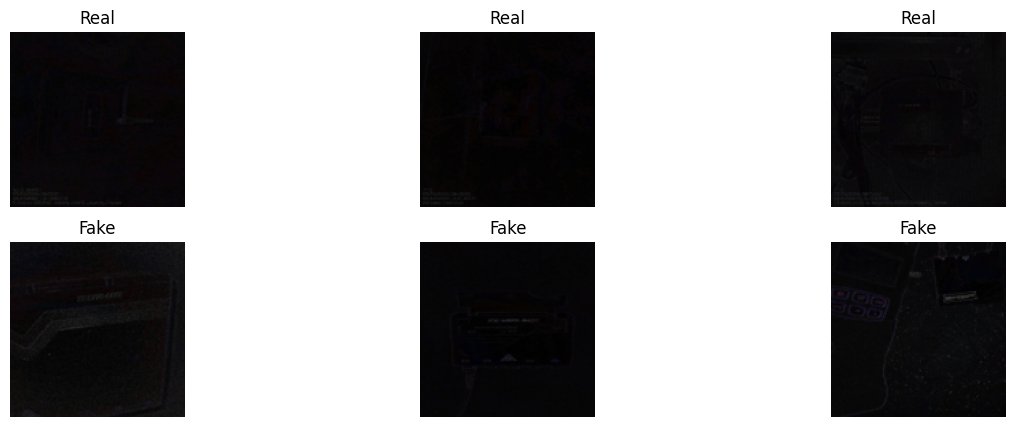

In [113]:

# Affichage des images ELA
plot_ela_images(images, labels, num_real=3, num_fake=3)

In [114]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [115]:
# Affichage des comptes d'images pour l'ensemble d'entraînement et de validation
print_image_counts(y_train, 'training')
print_image_counts(y_test, 'validation')

Number of real images in training dataset: 77
Number of fake images in training dataset: 55
Number of real images in validation dataset: 18
Number of fake images in validation dataset: 15


In [116]:
# Création du modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\qulebouc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [117]:
# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.4284 - loss: 0.7123 - val_accuracy: 0.5455 - val_loss: 0.6906
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.6228 - loss: 0.6821 - val_accuracy: 0.5455 - val_loss: 0.6901
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.6120 - loss: 0.6827 - val_accuracy: 0.5455 - val_loss: 0.6886
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.5794 - loss: 0.6839 - val_accuracy: 0.5455 - val_loss: 0.6881
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.5894 - loss: 0.6810 - val_accuracy: 0.5455 - val_loss: 0.6823
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.5564 - loss: 0.6762 - val_accuracy: 0.5455 - val_loss: 0.6772
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.5980 - loss: 0.6530 - val_accuracy: 0.6061 - val_loss: 0.6605
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.6486 - loss: 0.6617 - val_accuracy: 0.5758 - val_loss:

RESULTATS


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9081 - loss: 0.3904 
Loss: 0.3888048827648163
Accuracy: 0.9090909361839294
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


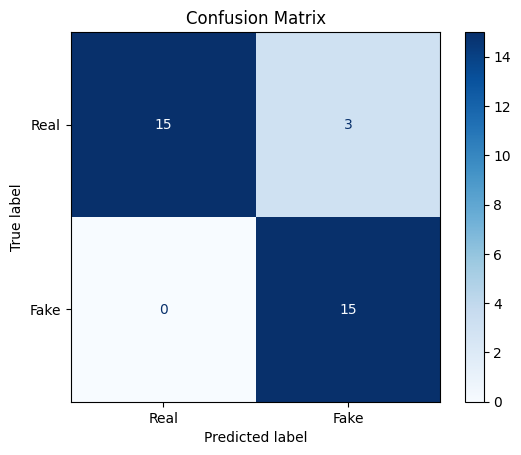

In [118]:
# Évaluation du modèle
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

# Affichage de la matrice de confusion
plot_confusion_matrix(model, X_test, y_test, class_names=['Real', 'Fake'])

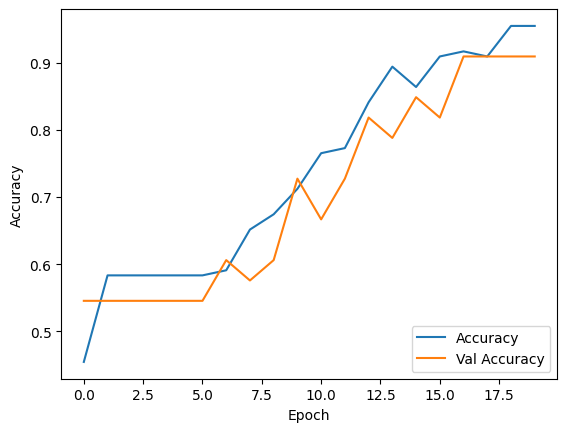

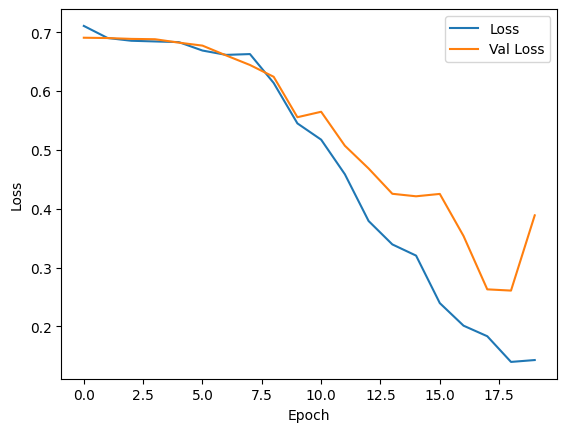

In [119]:
# Visualisation des résultats d'entraînement
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()